<a href="https://colab.research.google.com/github/JakubWalczykowski/projekt/blob/main/w_przod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f6f5d4aa023ddc7fefd18e68022c4155fbb0e8c7ccc44a462301924e65b257da
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pandas as pd
from datetime import timedelta
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')
from statsmodels.tsa.holtwinters import ExponentialSmoothing


Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import to_date, to_timestamp, date_format, year, month, concat_ws, dayofmonth, day, count, weekofyear, expr, col, asc

from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("Join CSV Files") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [4]:
#głowna baza
df1 = spark.read.csv('/content/drive/MyDrive/crime/Crimes_-_2001_to_Present_20240311.csv', header=True, inferSchema=True)
# dane statyczne
df2 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Languages_spoken_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df4 = spark.read.csv('/content/drive/MyDrive/crime/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical_20240301.csv', header=True, inferSchema=True)

In [5]:
#czyszczenie z nulli
years_to_drop = ['2001', '2002']
df1 = df1.filter(~df1['Year'].isin(years_to_drop)).dropna()
#joiny
df2 = df2.withColumnRenamed("Community Area Number", "Community Area")
joined_df = df1.join(df2, ["Community Area"]).drop(col("COMMUNITY AREA NAME"))
joined_df = joined_df.join(df3, ["Community Area"]).drop(col("Community Area Name"))
joined_df = joined_df.join(df4, ["Community Area"])
joined_df = joined_df.withColumn('Date', to_timestamp(joined_df['Date'], 'MM/dd/yyyy hh:mm:ss a'))
joined_df = joined_df.withColumn('Date_only', to_date(joined_df['Date']))
joined_df = joined_df.withColumn('Time_only', date_format(joined_df['Date'], 'HH:mm:ss'))


df = joined_df.orderBy('Date', ascending=True)
#archiwizacja całosci na s3

#output_path = "path/to/save/parquet_file"

#df.write.parquet(output_path)



In [6]:

class PredictionModel:
    def __init__(self, df):
        self.df = df

    def prepare_daily_data(self):
        daily_df = self.df.withColumn("Year", year("Date")) \
                          .withColumn("Month", month("Date")) \
                          .withColumn("Day", dayofmonth("Date"))
        daily_df = daily_df.withColumn("YearMonthDay", to_date(concat_ws("-", daily_df["Year"], daily_df["Month"], daily_df["Day"]), "yyyy-MM-dd"))
        daily_agg_df = daily_df.groupBy("Year", "Month", "Day", "YearMonthDay") \
                               .agg(count("*").cast("int").alias("Count")) \
                               .orderBy("YearMonthDay")
        pd_daily_agg_df = daily_agg_df.toPandas()
        pd_daily_agg_df.set_index('YearMonthDay', inplace=True)
        pd_daily_agg_df = pd_daily_agg_df.drop(pd_daily_agg_df.index[-7])
        pd_daily_agg_df = pd_daily_agg_df.drop(['Year', 'Month', 'Day'], axis=1)
        pd_daily_agg_df_reset = pd_daily_agg_df.reset_index()
        return pd_daily_agg_df_reset

    def prepare_weekly_data(self):
        week_df = self.df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))
        week_df = week_df.withColumn("YearWeek", concat_ws("-", week_df["Year"], F.format_string("%02d", week_df["Week"])))
        week_df = week_df.withColumn("WeekStartDate", expr("date_sub(next_day(to_date(concat(Year, '-01-01')), 'MO'), 8 - Week * 7)"))
        week_df = week_df.groupBy("Year", "Week", "YearWeek", "WeekStartDate").agg(F.count("*").cast("int").alias("Count")).orderBy("Year", "Week")
        pd_week_df = week_df.toPandas()
        pd_week_df.set_index('WeekStartDate', inplace=True)
        pd_week_df = pd_week_df.drop(pd_week_df.index[-1])
        pd_week_df = pd_week_df.drop(['Year', 'Week', 'YearWeek'], axis=1)
        pd_week_df = pd_week_df.reset_index()
        return pd_week_df

    def prepare_monthly_data(self):
        month_df = self.df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
        month_df = month_df.withColumn("YearMonth", concat_ws("-", month_df["Year"], month_df["Month"]))
        month_df = month_df.withColumn("YearMonth", to_date(month_df["YearMonth"], "yyyy-MM"))
        month_df = month_df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
        pd_month_df = month_df.toPandas()
        pd_month_df.set_index('YearMonth', inplace=True)
        pd_month_df = pd_month_df.drop(pd_month_df.index[-1])
        pd_month_df = pd_month_df.drop(['Year', 'Month'], axis=1)
        pd_month_df_reset = pd_month_df.reset_index()
        return pd_month_df_reset

    def fit_predict(self, data, seasonal_periods, N_test):
        train = data.iloc[:-N_test]
        test = data.iloc[-N_test:]

        train_idx = data.index <= train.index[-1]
        test_idx = data.index > train.index[-1]

        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        data.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
        data.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
        return data, train, test, res_hw

    def fit_predict_future(self, data, seasonal_periods, N_future):
        train = data
        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        future_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=N_future, freq='D')
        future_forecast = res_hw.forecast(N_future)

        future_data = pd.DataFrame({'HoltWinters': future_forecast}, index=future_index)
        return future_data, res_hw

    def plot(self, data):
        data[['Count', 'HoltWinters']].plot()

    def rmse(self, y, t):
        return np.sqrt(np.mean((y - t) ** 2))

    def mae(self, y, t):
        return np.mean(np.abs(y - t))

    def mape(self, y, t):
        return np.mean(np.abs((y - t) / y)) * 100

    def evaluate(self, train, test, res_hw, N_test):
        print("Train RMSE:", self.rmse(train['Count'], res_hw.fittedvalues))
        print("Test RMSE:", self.rmse(test['Count'], res_hw.forecast(N_test)))
        print("Train MAE:", self.mae(train['Count'], res_hw.fittedvalues))
        print("Test MAE:", self.mae(test['Count'], res_hw.forecast(N_test)))
        print("Train MAPE:", self.mape(train['Count'], res_hw.fittedvalues))
        print("Test MAPE:", self.mape(test['Count'], res_hw.forecast(N_test)))

In [7]:
daily_df = df.withColumn("Year", year("Date")) \
                          .withColumn("Month", month("Date")) \
                          .withColumn("Day", dayofmonth("Date"))
daily_df = daily_df.withColumn("YearMonthDay", to_date(concat_ws("-", daily_df["Year"], daily_df["Month"], daily_df["Day"]), "yyyy-MM-dd"))
daily_agg_df = daily_df.groupBy("Year", "Month", "Day", "YearMonthDay") \
                               .agg(count("*").cast("int").alias("Count")) \
                               .orderBy("YearMonthDay")
pd_daily_agg_df = daily_agg_df.toPandas()
pd_daily_agg_df.set_index('YearMonthDay', inplace=True)
pd_daily_agg_df = pd_daily_agg_df.drop(pd_daily_agg_df.index[-7])
pd_daily_agg_df = pd_daily_agg_df.drop(['Year', 'Month', 'Day'], axis=1)
pd_daily_agg_df_reset = pd_daily_agg_df.reset_index()
pd_daily_agg_df_reset['YearMonthDay'] = pd.to_datetime(pd_daily_agg_df_reset['YearMonthDay'])
pd_daily_agg_df_reset.set_index('YearMonthDay', inplace=True)




In [8]:
week_df = df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))
week_df = week_df.withColumn("YearWeek", concat_ws("-", week_df["Year"], F.format_string("%02d", week_df["Week"])))
week_df = week_df.withColumn("WeekStartDate", expr("date_sub(next_day(to_date(concat(Year, '-01-01')), 'MO'), 8 - Week * 7)"))
week_df = week_df.groupBy("Year", "Week", "YearWeek", "WeekStartDate").agg(F.count("*").cast("int").alias("Count")).orderBy("Year", "Week")
pd_week_df = week_df.toPandas()
pd_week_df.set_index('WeekStartDate', inplace=True)
pd_week_df = pd_week_df.drop(pd_week_df.index[-1])
#pd_week_df = pd_week_df.drop(['Year', 'Week', 'YearWeek'], axis=1)
pd_week_df = pd_week_df.reset_index()

In [9]:
pd_week_df.max()

WeekStartDate    2024-02-25
Year                   2024
Week                     53
YearWeek            2024-08
Count                 10125
dtype: object

In [10]:
month_df = df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
month_df = month_df.withColumn("YearMonth", concat_ws("-", month_df["Year"], month_df["Month"]))
month_df = month_df.withColumn("YearMonth", to_date(month_df["YearMonth"], "yyyy-MM"))
month_df = month_df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
pd_month_df = month_df.toPandas()
pd_month_df.set_index('YearMonth', inplace=True)
pd_month_df = pd_month_df.drop(pd_month_df.index[-1])
pd_month_df = pd_month_df.drop(['Year', 'Month'], axis=1)
pd_month_df_reset = pd_month_df.reset_index()

In [11]:
pd_daily_agg_df_reset

,Count
YearMonthDay,
2003-01-01,1810
2003-01-02,1154
2003-01-03,1286
2003-01-04,1148
2003-01-05,1078
...,...
2024-02-28,609
2024-02-29,653
2024-03-01,640


In [12]:
pd_month_df_reset

,YearMonth,Count
0,2003-01-01,35960
1,2003-02-01,32420
2,2003-03-01,38565
3,2003-04-01,39665
4,2003-05-01,41061
...,...,...
249,2023-10-01,22812
250,2023-11-01,21102
251,2023-12-01,20926
252,2024-01-01,19014


In [13]:
d_start_date = pd_daily_agg_df_reset.index.max() + pd.DateOffset(days=1)
d_end_date = d_start_date + pd.DateOffset(days=364)
d_new_dates = pd.date_range(start=d_start_date, end=d_end_date, freq='D')

new_df = pd.DataFrame({'Count': np.nan}, index=d_new_dates)


In [ ]:
hw = ExponentialSmoothing(
    pd_daily_agg_df_reset['Count'],
    initialization_method='legacy-heuristic',
    trend='add',
    seasonal='add',
    seasonal_periods=365
)
res_hw = hw.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
forecast = res_hw.forecast(365)

# Assign forecasted values to new_df
new_df['Count'] = forecast.values


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
pd_daily_agg_df_reset['HoltWinters'] = res_hw.fittedvalues
new_df['HoltWinters'] = forecast.values

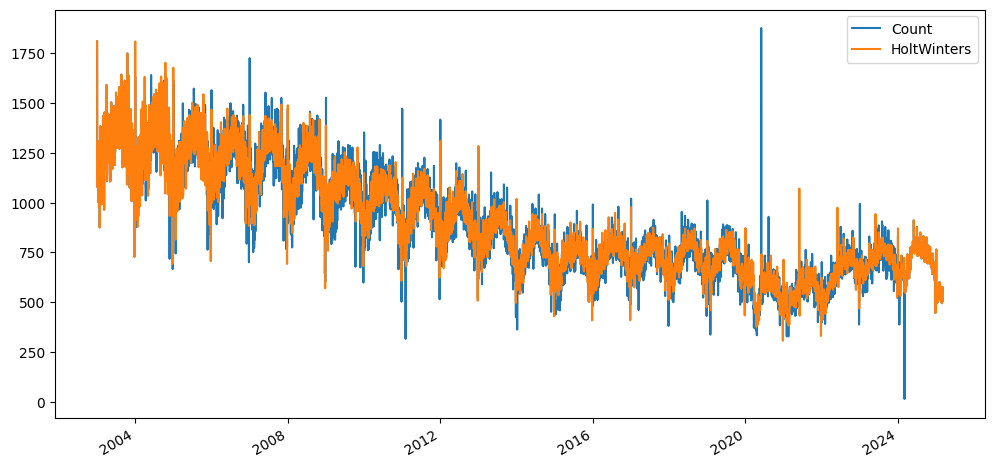

In [ ]:
combined_df = pd.concat([pd_daily_agg_df_reset, new_df])

# Plot the results
combined_df[['Count', 'HoltWinters']].plot(figsize=(12, 6))
plt.show()

In [ ]:
hw_full = ExponentialSmoothing(
    pd_daily_agg_df_reset['Count'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=365)
res_hw_full = hw_full.fit()

In [ ]:
new_df['Count'] = res_hw_full.forecast(len(new_df))

In [ ]:
new_df

,Count
YearMonthDay,
2024-03-04,NaN
2024-03-05,NaN
2024-03-06,NaN
2024-03-07,NaN
2024-03-08,NaN
...,...
2025-02-27,NaN
2025-02-28,NaN
2025-03-01,NaN


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-03-04 to 2025-03-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   0 non-null      float64
dtypes: float64(1)
memory usage: 5.7 KB


In [ ]:
pd_daily_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7732 entries, 2003-01-01 to 2024-03-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   7732 non-null   int32
dtypes: int32(1)
memory usage: 348.6+ KB


In [ ]:
combined_df = pd.concat([pd_daily_agg_df[['Count']], new_df[['Count']]])

In [ ]:
combined_df

,Count
YearMonthDay,
2003-01-01,1810.0
2003-01-02,1154.0
2003-01-03,1286.0
2003-01-04,1148.0
2003-01-05,1078.0
...,...
2025-02-27 00:00:00,NaN
2025-02-28 00:00:00,NaN
2025-03-01 00:00:00,NaN


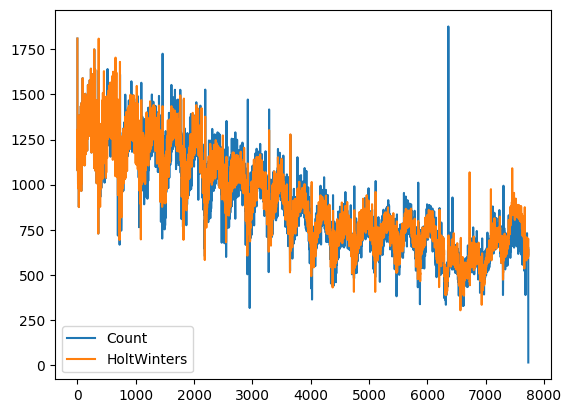

In [ ]:
N_test = 365
train = pd_daily_agg_df_reset.iloc[:-N_test]
test = pd_daily_agg_df_reset.iloc[-N_test:]

train_idx = pd_daily_agg_df_reset.index <= train.index[-1]
test_idx = pd_daily_agg_df_reset.index > train.index[-1]

hw = ExponentialSmoothing(
    train['Count'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=365)
res_hw = hw.fit()



pd_daily_agg_df_reset.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

pd_daily_agg_df_reset.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
pd_daily_agg_df_reset[['Count', 'HoltWinters']].plot();

Train RMSE: 87.32702774782507
Test RMSE: 108.03991432917397
Train MAE: 61.7896771761865
Test MAE: 86.4246326064257
Train MAPE: 7.203696551128082
Test MAPE: 24.521338788779467


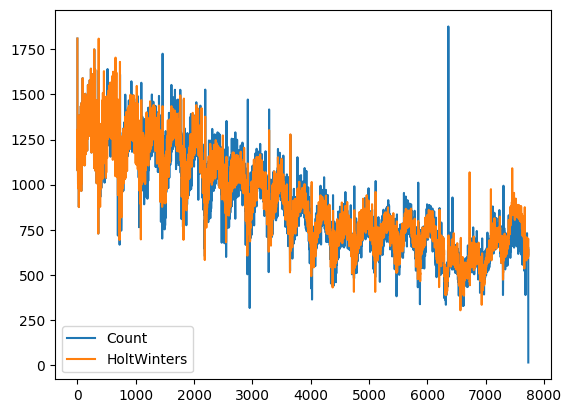

In [ ]:
model = PredictionModel(df)

# Daily
pd_daily_agg_df_reset = model.prepare_daily_data()
daily_data, daily_train, daily_test, daily_res_hw = model.fit_predict(pd_daily_agg_df_reset, seasonal_periods=365, N_test=365)
model.plot(daily_data)
model.evaluate(daily_train, daily_test, daily_res_hw, N_test=365)


Train RMSE: 519.7008881685979
Test RMSE: 386.25413449261725
Train MAE: 324.04475367399846
Test MAE: 281.8174674270608
Train MAPE: 6.173699642631453
Test MAPE: 5.792927390309174


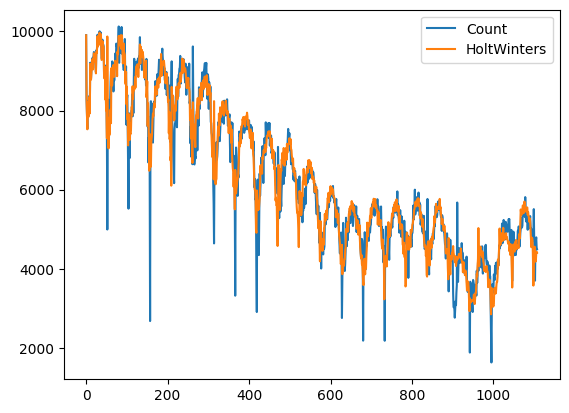

In [ ]:
model = PredictionModel(df)


pd_week_df = model.prepare_weekly_data()
weekly_data, weekly_train, weekly_test, weekly_res_hw = model.fit_predict(pd_week_df, seasonal_periods=52, N_test=52)
model.plot(weekly_data)
model.evaluate(weekly_train, weekly_test, weekly_res_hw, N_test=52)

Train RMSE: 1111.214508127352
Test RMSE: 752.9695038461591
Train MAE: 807.9794757051395
Test MAE: 583.5029950656208
Train MAPE: 3.3322640446573453
Test MAPE: 2.8559820972477707


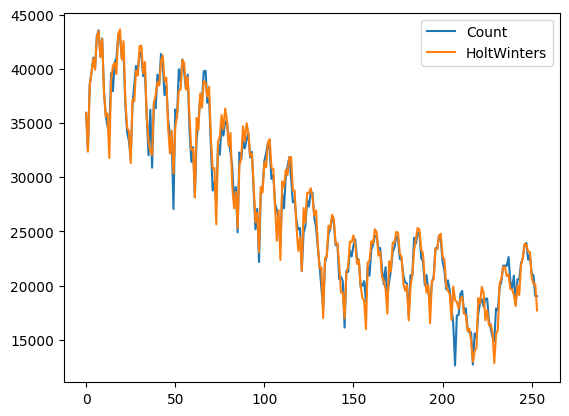

In [ ]:
model = PredictionModel(df)


pd_month_df_reset = model.prepare_monthly_data()
monthly_data, monthly_train, monthly_test, monthly_res_hw = model.fit_predict(pd_month_df_reset, seasonal_periods=12, N_test=12)
model.plot(monthly_data)
model.evaluate(monthly_train, monthly_test, monthly_res_hw, N_test=12)

In [ ]:
def fit_predict_future(self, data, seasonal_periods, N_future):
    """

    Args:
      self:
      data:
      seasonal_periods:
      N_future:

    Returns:

    """
    hw = ExponentialSmoothing(data['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    res_hw = hw.fit()

    future_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=N_future, freq='D')
    future_forecast = res_hw.forecast(N_future)

    future_data = pd.DataFrame({'HoltWinters': future_forecast}, index=future_index)
    return future_data, res_hw

In [ ]:
pd_daily_agg_df_reset = model.prepare_daily_data()

# Fit the model
daily_data, daily_res_hw = model.fit_predict_future(pd_daily_agg_df_reset, seasonal_periods=365, N_future=30)  # Adjust N_future as needed

# Plot the results
model.plot(daily_data)

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

In [ ]:

class PredictionModel:
    def __init__(self, df):
        self.df = df

    def prepare_daily_data(self):
        daily_df = self.df.withColumn("Year", year("Date")) \
                          .withColumn("Month", month("Date")) \
                          .withColumn("Day", dayofmonth("Date"))
        daily_df = daily_df.withColumn("YearMonthDay", to_date(concat_ws("-", daily_df["Year"], daily_df["Month"], daily_df["Day"]), "yyyy-MM-dd"))
        daily_agg_df = daily_df.groupBy("Year", "Month", "Day", "YearMonthDay") \
                               .agg(count("*").cast("int").alias("Count")) \
                               .orderBy("YearMonthDay")
        pd_daily_agg_df = daily_agg_df.toPandas()
        pd_daily_agg_df.set_index('YearMonthDay', inplace=True)
        pd_daily_agg_df = pd_daily_agg_df.drop(pd_daily_agg_df.index[-7])
        pd_daily_agg_df = pd_daily_agg_df.drop(['Year', 'Month', 'Day'], axis=1)

        # Add future dates
        future_dates = pd.date_range(start=pd_daily_agg_df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
        future_df = pd.DataFrame(index=future_dates, columns=pd_daily_agg_df.columns)
        pd_daily_agg_df = pd_daily_agg_df.append(future_df)

        pd_daily_agg_df_reset = pd_daily_agg_df.reset_index()
        return pd_daily_agg_df_reset

    def prepare_weekly_data(self):
        week_df = self.df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))
        week_df = week_df.withColumn("YearWeek", concat_ws("-", week_df["Year"], F.format_string("%02d", week_df["Week"])))
        week_df = week_df.withColumn("WeekStartDate", expr("date_sub(next_day(to_date(concat(Year, '-01-01')), 'MO'), 8 - Week * 7)"))
        week_df = week_df.groupBy("Year", "Week", "YearWeek", "WeekStartDate").agg(F.count("*").cast("int").alias("Count")).orderBy("Year", "Week")
        pd_week_df = week_df.toPandas()
        pd_week_df.set_index('WeekStartDate', inplace=True)
        pd_week_df = pd_week_df.drop(pd_week_df.index[-1])
        pd_week_df = pd_week_df.drop(['Year', 'Week', 'YearWeek'], axis=1)
        pd_week_df = pd_week_df.reset_index()
        return pd_week_df

    def prepare_monthly_data(self):
        month_df = self.df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
        month_df = month_df.withColumn("YearMonth", concat_ws("-", month_df["Year"], month_df["Month"]))
        month_df = month_df.withColumn("YearMonth", to_date(month_df["YearMonth"], "yyyy-MM"))
        month_df = month_df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
        pd_month_df = month_df.toPandas()
        pd_month_df.set_index('YearMonth', inplace=True)
        pd_month_df = pd_month_df.drop(pd_month_df.index[-1])
        pd_month_df = pd_month_df.drop(['Year', 'Month'], axis=1)
        pd_month_df_reset = pd_month_df.reset_index()
        return pd_month_df_reset

    def fit_predict(self, data, seasonal_periods, N_test):
        train = data.iloc[:-N_test]
        test = data.iloc[-N_test:]

        train_idx = data.index <= train.index[-1]
        test_idx = data.index > train.index[-1]

        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        data.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
        data.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
        return data, train, test, res_hw

    def fit_predict_future(self, data, seasonal_periods, N_future):
        train = data
        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        future_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=N_future, freq='D')
        future_forecast = res_hw.forecast(N_future)

        future_data = pd.DataFrame({'HoltWinters': future_forecast}, index=future_index)
        return future_data, res_hw

    def create_validation_dataframe(data, days=365):
        last_date = data['YearMonthDay'].max()
        new_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)
        validation_df = pd.DataFrame(new_dates, columns=['YearMonthDay'])
        validation_df['Count'] = 0  # or np.nan if you prefer
        return validation_df

    def plot(self, data):
        data[['Count', 'HoltWinters']].plot()

    def rmse(self, y, t):
        return np.sqrt(np.mean((y - t) ** 2))

    def mae(self, y, t):
        return np.mean(np.abs(y - t))

    def mape(self, y, t):
        return np.mean(np.abs((y - t) / y)) * 100

    def evaluate(self, train, test, res_hw, N_test):
        print("Train RMSE:", self.rmse(train['Count'], res_hw.fittedvalues))
        print("Test RMSE:", self.rmse(test['Count'], res_hw.forecast(N_test)))
        print("Train MAE:", self.mae(train['Count'], res_hw.fittedvalues))
        print("Test MAE:", self.mae(test['Count'], res_hw.forecast(N_test)))
        print("Train MAPE:", self.mape(train['Count'], res_hw.fittedvalues))
        print("Test MAPE:", self.mape(test['Count'], res_hw.forecast(N_test)))

In [ ]:
pd_daily_agg_df_reset


,YearMonthDay,Count
0,2003-01-01,1810
1,2003-01-02,1154
2,2003-01-03,1286
3,2003-01-04,1148
4,2003-01-05,1078
...,...,...
7727,2024-02-28,609
7728,2024-02-29,653
7729,2024-03-01,640
7730,2024-03-02,600


In [ ]:
future_df

NameError: name 'future_df' is not defined

In [ ]:
class PredictionModel:
    def __init__(self, df):
        self.df = df

    def prepare_daily_data(self):
        daily_df = self.df.withColumn("Year", year("Date")) \
                          .withColumn("Month", month("Date")) \
                          .withColumn("Day", dayofmonth("Date"))
        daily_df = daily_df.withColumn("YearMonthDay", to_date(concat_ws("-", daily_df["Year"], daily_df["Month"], daily_df["Day"]), "yyyy-MM-dd"))
        daily_agg_df = daily_df.groupBy("Year", "Month", "Day", "YearMonthDay") \
                               .agg(count("*").cast("int").alias("Count")) \
                               .orderBy("YearMonthDay")
        pd_daily_agg_df = daily_agg_df.toPandas()
        pd_daily_agg_df.set_index('YearMonthDay', inplace=True)
        pd_daily_agg_df = pd_daily_agg_df.drop(pd_daily_agg_df.index[-7])
        pd_daily_agg_df = pd_daily_agg_df.drop(['Year', 'Month', 'Day'], axis=1)
        pd_daily_agg_df_reset = pd_daily_agg_df.reset_index()
        return pd_daily_agg_df_reset

    def prepare_weekly_data(self):
        week_df = self.df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))
        week_df = week_df.withColumn("YearWeek", concat_ws("-", week_df["Year"], F.format_string("%02d", week_df["Week"])))
        week_df = week_df.withColumn("WeekStartDate", expr("date_sub(next_day(to_date(concat(Year, '-01-01')), 'MO'), 8 - Week * 7)"))
        week_df = week_df.groupBy("Year", "Week", "YearWeek", "WeekStartDate").agg(F.count("*").cast("int").alias("Count")).orderBy("Year", "Week")
        pd_week_df = week_df.toPandas()
        pd_week_df.set_index('WeekStartDate', inplace=True)
        pd_week_df = pd_week_df.drop(pd_week_df.index[-1])
        pd_week_df = pd_week_df.drop(['Year', 'Week', 'YearWeek'], axis=1)
        pd_week_df = pd_week_df.reset_index()
        return pd_week_df

    def prepare_monthly_data(self):
        month_df = self.df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
        month_df = month_df.withColumn("YearMonth", concat_ws("-", month_df["Year"], month_df["Month"]))
        month_df = month_df.withColumn("YearMonth", to_date(month_df["YearMonth"], "yyyy-MM"))
        month_df = month_df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
        pd_month_df = month_df.toPandas()
        pd_month_df.set_index('YearMonth', inplace=True)
        pd_month_df = pd_month_df.drop(pd_month_df.index[-1])
        pd_month_df = pd_month_df.drop(['Year', 'Month'], axis=1)
        pd_month_df_reset = pd_month_df.reset_index()
        return pd_month_df_reset

    def fit_predict(self, data, seasonal_periods, N_test):
        train = data.iloc[:-N_test]
        test = data.iloc[-N_test:]

        train_idx = data.index <= train.index[-1]
        test_idx = data.index > train.index[-1]

        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        data.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
        data.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
        return data, train, test, res_hw

    def fit_predict_future(self, data, seasonal_periods, N_future):
        train = data
        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        future_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=N_future, freq='D')
        future_forecast = res_hw.forecast(N_future)

        future_data = pd.DataFrame({'HoltWinters': future_forecast}, index=future_index)
        return future_data, res_hw

    def plot(self, data):
        data[['Count', 'HoltWinters']].plot()

    def rmse(self, y, t):
        return np.sqrt(np.mean((y - t) ** 2))

    def mae(self, y, t):
        return np.mean(np.abs(y - t))

    def mape(self, y, t):
        return np.mean(np.abs((y - t) / y)) * 100

    def evaluate(self, train, test, res_hw, N_test):
        print("Train RMSE:", self.rmse(train['Count'], res_hw.fittedvalues))
        print("Test RMSE:", self.rmse(test['Count'], res_hw.forecast(N_test)))
        print("Train MAE:", self.mae(train['Count'], res_hw.fittedvalues))
        print("Test MAE:", self.mae(test['Count'], res_hw.forecast(N_test)))
        print("Train MAPE:", self.mape(train['Count'], res_hw.fittedvalues))
        print("Test MAPE:", self.mape(test['Count'], res_hw.forecast(N_test)))



fit_predict_future create call for that functuion